In [ ]:
# Download data and extract into path/data

%%capture

!wget -P data/ https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
!unzip -n data/train-test-data.zip -d data

In [38]:
import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import torch
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader

import cv2

In [11]:
keypoints_frame = pd.read_csv('data/training_frames_keypoints.csv')

In [12]:
keypoints_frame.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,126,127,128,129,130,131,132,133,134,135
0,Luis_Fonsi_21.jpg,45.0,98.0,47.0,106.0,49.0,110.0,53.0,119.0,56.0,...,83.0,119.0,90.0,117.0,83.0,119.0,81.0,122.0,77.0,122.0
1,Lincoln_Chafee_52.jpg,41.0,83.0,43.0,91.0,45.0,100.0,47.0,108.0,51.0,...,85.0,122.0,94.0,120.0,85.0,122.0,83.0,122.0,79.0,122.0
2,Valerie_Harper_30.jpg,56.0,69.0,56.0,77.0,56.0,86.0,56.0,94.0,58.0,...,79.0,105.0,86.0,108.0,77.0,105.0,75.0,105.0,73.0,105.0
3,Angelo_Reyes_22.jpg,61.0,80.0,58.0,95.0,58.0,108.0,58.0,120.0,58.0,...,98.0,136.0,107.0,139.0,95.0,139.0,91.0,139.0,85.0,136.0
4,Kristen_Breitweiser_11.jpg,58.0,94.0,58.0,104.0,60.0,113.0,62.0,121.0,67.0,...,92.0,117.0,103.0,118.0,92.0,120.0,88.0,122.0,84.0,122.0


In [62]:
# select an image by index n
n = 0
image_name = keypoints_frame.iloc[n, 0]
keypoints = keypoints_frame.iloc[n, 1:]
# change from pandas series to numpy array, reshape to (num_keypoints, 2)
keypoints = keypoints.values.reshape(-1, 2)
print(image_name)
print(keypoints.shape)


Luis_Fonsi_21.jpg
(68, 2)


(192, 176, 4)


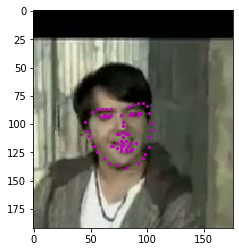

In [63]:
image = mpimg.imread(os.path.join('data/training/', image_name))
print(image.shape)

def plot_face_keypoints(image, keypoints):
    plt.imshow(image)
    plt.scatter(keypoints[:, 0], keypoints[:, 1], s=20, marker='.', c='m')

plot_face_keypoints(image, keypoints)

In [119]:
# Adapted from: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

class FacialKeypointsDataset(Dataset):
    def __init__(self, csv_file, path_base, transform=None):
        self.keypoints_frame = pd.read_csv(csv_file)
        self.path_base = path_base
        self.transform = transform
        
    def __len__(self):
        return len(self.keypoints_frame)
    
    # read images here instead of init to save memory
    def __getitem__(self, idx):
        """
        Returns a dictionary of:
        {"image": image, "keypoints": keypoints}
        """
        
        image_name = self.keypoints_frame.iloc[idx, 0]
        image = mpimg.imread(os.path.join(self.path_base, image_name))
        
        # if image has an alpha color channel (4th), get rid of it
        if(image.shape[2] == 4):
            image = image[:,:,0:3]
            
        keypoints = self.keypoints_frame.iloc[idx, 1:]
        # change from pandas series to numpy array, reshape to (num_keypoints, 2)
        keypoints = keypoints.to_numpy().astype('float').reshape(-1, 2)
        
        sample = {"image": image, "keypoints": keypoints}
        
        if self.transform:
            sample = self.transform(sample)
        
        return sample
        

In [120]:
data_train = FacialKeypointsDataset(csv_file='data/training_frames_keypoints.csv',
                                   path_base='data/training/')

print("No of training data: ", len(data_train))

No of training data:  3462


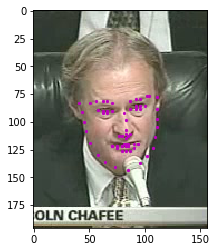

In [121]:
sample = data_train[1]
plot_face_keypoints(sample['image'], sample['keypoints'])

In [37]:
for idx in range(5):
    sample = data_train[idx]
    print("Image shape: ", sample['image'].shape)

Image shape:  (192, 176, 3)
Image shape:  (196, 157, 3)
Image shape:  (190, 170, 3)
Image shape:  (240, 213, 3)
Image shape:  (191, 184, 3)


The shapes of the images are dissimilar, and we'll need to resize them to the same shape before feeding into the neural network.

Therefore, we will need to write some pre-processing code.
Let's create four transforms:

-  ``Normalize``: to convert a color image to grayscale values with a range of [0,1] and normalize the keypoints to be in a range of about [-1, 1]
-  ``Rescale``: to rescale an image to a desired size.
-  ``RandomCrop``: to crop an image randomly.
-  ``ToTensor``: to convert numpy images to torch images.


We will write them as callable classes instead of simple functions so
that parameters of the transform need not be passed everytime it's
called. For this, we just need to implement ``__call__`` method and 
(if we require parameters to be passed in), the ``__init__`` method. 
We can then use a transform like this:

    tx = Transform(params)
    transformed_sample = tx(sample)

In [58]:
class Normalize(object):

    def __call__(self, sample):
        image, keypoints = sample['image'], sample['keypoints']
        
        image_copy = np.copy(image)
        keypoints_copy = np.copy(keypoints)

        # convert image to grayscale
        image_copy = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        
        # scale color range from [0, 255] to [0, 1]
        image_copy=  image_copy/255.0
        
        # scale keypoints to be centered around 0 with a range of [-1, 1]
        # mean = 100, sqrt = 50, so, pts should be (pts - 100)/50
        keypoints_copy = (keypoints_copy - 100)/50.0

        return {'image': image_copy, 'keypoints': keypoints_copy}


class Rescale(object):
    def __init__(self, output_size):
        # If tuple, output is matched to output_size. 
        # If int, smaller of image edges is matched to output_size keeping aspect ratio the same.
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, keypoints = sample['image'], sample['keypoints']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = cv2.resize(image, (new_w, new_h))
        
        # scale the pts, too
        keypoints = keypoints * [new_w / w, new_h / h]

        return {'image': img, 'keypoints': keypoints}


class RandomCrop(object):
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            #If int, square crop is made
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, keypoints = sample['image'], sample['keypoints']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        keypoints = keypoints - [left, top]

        return {'image': image, 'keypoints': keypoints}


class ToTensor(object):
    def __call__(self, sample):
        image, keypoints = sample['image'], sample['keypoints']
         
        # if image has no grayscale color channel, add one
        if(len(image.shape) == 2):
            # add that third color dim
            image = image.reshape(image.shape[0], image.shape[1], 1)
            
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        
        return {'image': torch.from_numpy(image),
                'keypoints': torch.from_numpy(keypoints)}

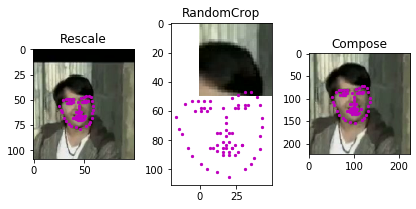

In [66]:
# test out some of these transforms
rescale = Rescale(100)
crop = RandomCrop(50)
composed = transforms.Compose([Rescale(250),
                               RandomCrop(224)])

# apply the transforms to a sample image
sample = data_train[0]

fig = plt.figure()
for i, tx in enumerate([rescale, crop, composed]):
    transformed_sample = tx(sample)

    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tx).__name__)
    plot_face_keypoints(transformed_sample['image'], transformed_sample['keypoints'])

plt.show()

In [122]:
data_transform = transforms.Compose([Rescale(250),
                                     RandomCrop(224),
                                     Normalize(),
                                     ToTensor()])

# create the transformed dataset
data_train_trans = FacialKeypointsDataset(csv_file='data/training_frames_keypoints.csv',
                                             path_base='data/training/',
                                             transform=data_transform)

print("No of transformed training data: ", len(data_train_trans))

No of transformed training data:  3462


In [124]:
# make sure the sample tensors are the expected size
for i in range(5):
    sample = data_train_trans[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])
4 torch.Size([1, 224, 224]) torch.Size([68, 2])


numpy.ndarray

In [125]:
import torch
import torch.nn as nn
import torch.nn.functional as F
# can use the below import should you choose to initialize the weights of your Net
import torch.nn.init as I


class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        
        ## 1. This network takes in a square (same width and height), grayscale image as input
        ## 2. It ends with a linear layer that represents the keypoints
        
        # output size = (N - F)/stride + 1
        # from (1, 224, 224) to (32, 220, 220) 
        self.conv1 = nn.Conv2d(1, 32, 5)
        
        # conv1 from (32, 220, 220) to (32, 110, 110)
        # conv2 from (64, 106, 106) to (64, 53, 53)
        self.pool = nn.MaxPool2d(2, 2)
        
        # output size = (N - F)/stride + 1
        # from (32, 110, 110) to (64, 106, 106)
        self.conv2 = nn.Conv2d(32, 64, 5)
        
        # from (64, 53, 53) to (10000)
        self.fc1 = nn.Linear(64*53*53, 10000)
        
        # dropout with p=0.4
        self.fc1_drop = nn.Dropout(p=0.4)
        
        # last layer should have 136 values, 2 for each of the 68 keypoint (x, y) pairs
        # from (10000) to (136)
        self.fc2 = nn.Linear(10000, 136)

        
    def forward(self, x):

        x = self.pool(F.relu(self.conv1(x)))
        
        x = self.pool(F.relu(self.conv2(x)))
        
        # flatten
        x = x.view(x.size(0), -1)
        
        # two linear layers 
        x = F.relu(self.fc1(x))
        x = self.fc1_drop(x)
        x = self.fc2(x)
        # a softmax layer to convert the 10 outputs into a distribution of class scores
        x = F.log_softmax(x, dim=1)
        return x


In [126]:
net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=179776, out_features=10000, bias=True)
  (fc1_drop): Dropout(p=0.4, inplace=False)
  (fc2): Linear(in_features=10000, out_features=136, bias=True)
)
